In [6]:

%load_ext autoreload
%autoreload 2

from typing import List, Optional
from omegaconf import OmegaConf
import os
import time
import json
import wandb
import logging
import argparse

import torch
from utils.mytools import Grid2d
from utils.grid_numba import Grid2dNumba


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
points = torch.load("/home/a/drivestudio/notebook/data/points.pth")
grounds = torch.load("/home/a/drivestudio/notebook/data//grounds.pth")
flow_class = torch.load("/home/a/drivestudio/notebook/data//flow_class.pth")
cameras = torch.load("/home/a/drivestudio/notebook/data//cameras.pth")

In [ ]:
import matplotlib.pyplot as plt

def plot_lidar_points(lidar_points, ground_mask=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(lidar_points[:, 0][~ground_mask], lidar_points[:, 1][~ground_mask], c='b', s=1)  # 2D scatter plot
    plt.title('2D Lidar Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_lidar_points(points.numpy(), grounds.numpy())  # Convert to numpy array for plotting


In [ ]:
import torch.nn.functional as F

def create_voxel_grid_2d(lidar_points, voxel_size=1):
    z = lidar_points[:, 2]
    lidar_points = lidar_points[(-1 <= z) & (z <= 3)]
    x_min, x_max = lidar_points[:, 0].min(), lidar_points[:, 0].max()
    y_min, y_max = lidar_points[:, 1].min(), lidar_points[:, 1].max()
    
    grid_size_x = int((x_max - x_min) / voxel_size) + 1
    grid_size_y = int((y_max - y_min) / voxel_size) + 1
    
    voxel_grid = torch.zeros((grid_size_x, grid_size_y), dtype=torch.int32)
    
    # 计算每个点的体素索引
    voxel_indices_x = ((lidar_points[:, 0] - x_min) / voxel_size).long()
    voxel_indices_y = ((lidar_points[:, 1] - y_min) / voxel_size).long()
    
    # 将二维索引展平成一维索引
    flat_indices = voxel_indices_x * grid_size_y + voxel_indices_y
    
    # 使用 torch.bincount 统计每个体素的点数量
    counts = torch.bincount(flat_indices, minlength=grid_size_x * grid_size_y)
    
    # 将一维结果重塑为二维网格
    voxel_grid = counts.view(grid_size_x, grid_size_y)
    
    return voxel_grid

p = points[~grounds]
c = flow_class[~grounds]

# 生成2D体素网格
voxel_grid_2d = create_voxel_grid_2d(p[c<=0])


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(voxel_grid_2d.numpy() > 3, cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()


In [198]:
from utils.mytools import Camera, Grid2d, CameraSet, Grid2dNumba
grid = Grid2d(points, grounds, flow_class, cameras)

In [199]:
grid_numba = Grid2dNumba(grid, radius=8)

In [200]:
area_coverage = grid_numba.get_area_coverage()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000


In [203]:
grid_numba.area_coverage = area_coverage
cov_map = grid_numba.get_shown_map_base_on_angel(9)
grid_numba.fov

array(0.86961025, dtype=float32)

In [196]:
import numpy as np
map = grid.get_hot_map().numpy()
canvas = np.zeros_like(map)
canvas[map > 0] = -1
canvas[cov_map > 0] = cov_map[cov_map > 0] * 10



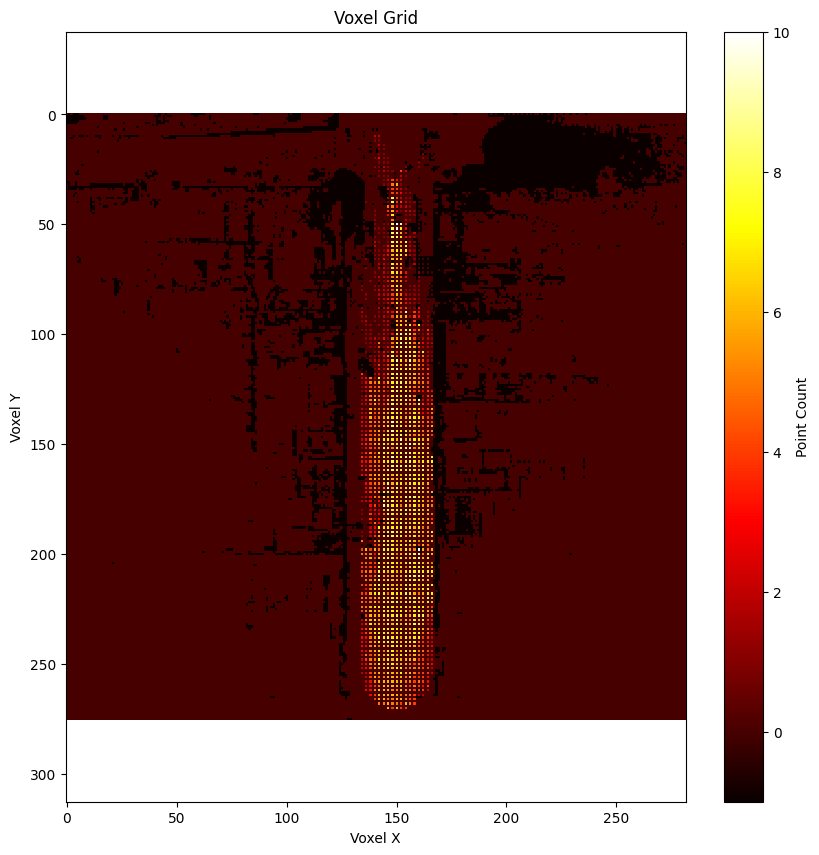

In [204]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='hot', interpolation='nearest')
# 限制
#plt.clim(0, 1)
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()

In [ ]:
coverages = []
for cam in cameras.values():
    print(cam)
    coverages.append(grid.get_camera_set_coverage(CameraSet(cam.cam_to_worlds, cam.intrinsics)))
print(coverages)

In [ ]:
camera = Camera(pose, intrinsic)
grid.get_camera_coverage(camera)